# Using the scikit-uplift package for uplift prediction on the Hillstrom's MineThatData E-Mail Analytics And Data Mining Challenge dataset

## Introduction

The Hillstrom's MineThatData E-Mail Analytics And Data Mining Challenge dataset contains 64,000 customers involved in an e-mail campaign.
The customers are randomly divided into three equal groups:

* the first group receives an e-mail campaign on Mens merchandise;
* the second group receives an e-mail campaign on Womens merchandise;
* the third group does not receive any campaign.

Since the customers receiving a treatment have the same probability of belonging to one of the three segments, the propensity score is known.

In this test we consider only one e-mail campaign at a time, therefore we exclude the individuals having received the other treatment.
This means that the propensity score of each customer is 0.5.

## Models

We test here multiple approaches:

* Single Model with treatment as a feature
* Single Model with treatment interaction
* Class transformation approach
* Two Model with independent training of the models (vanilla)
* Two Model training control first
* Two Model training treatment first

In [120]:
import pandas as pd
from sklift.models import SoloModel, ClassTransformation, TwoModels

from sklearn.ensemble import RandomForestClassifier

from causalml.metrics import plot_gain, auuc_score
import matplotlib.pyplot as plt

%matplotlib inline

In [121]:
from datasets import HillstromDataset

### Loading the data

We choose which campaign to analyze by changing the *campaign* parameter of *getCampaignData*. By choosing 1, we target
the Mens campaign, while by choosing 2 we target the Womens campaign.

We define the following vectors:
* y, the outcome
* X, the features
* w, the treatment indicator
* p, the propensity score

We split the data into a train set and a test set. In this test, the two sets have equal size.

In [122]:
data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=1)

### CATE estimation

We initialize our base learners using a Random Forest model and we estimate the CATE. To do so, we train the model with the train set
and we predict the CATE on the test set.

In [123]:
solo_model = SoloModel(RandomForestClassifier())
solo_model = solo_model.fit(X_train, y_train, w_train)
pred_1 = solo_model.predict(X_test)

solo_model_w_treatment = SoloModel(RandomForestClassifier(), method='treatment_interaction')
solo_model_w_treatment = solo_model_w_treatment.fit(X_train, y_train, w_train)
pred_2 = solo_model_w_treatment.predict(X_test)

class_model = ClassTransformation(RandomForestClassifier())
class_model = class_model.fit(X_train, y_train, w_train)
pred_3 = class_model.predict(X_test)

two_models_vanilla = TwoModels(estimator_trmnt=RandomForestClassifier(), estimator_ctrl=RandomForestClassifier())
two_models_vanilla = two_models_vanilla.fit(X_train, y_train, w_train)
pred_4 = two_models_vanilla.predict(X_test)

two_models_c = TwoModels(estimator_trmnt=RandomForestClassifier(), estimator_ctrl=RandomForestClassifier(), method='ddr_control')
two_models_c = two_models_c.fit(X_train, y_train, w_train)
pred_5 = two_models_c.predict(X_test)

two_models_t = TwoModels(estimator_trmnt=RandomForestClassifier(), estimator_ctrl=RandomForestClassifier(), method='ddr_treatment')
two_models_t = two_models_t.fit(X_train, y_train, w_train)
pred_6 = two_models_t.predict(X_test)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


### Uplift curve

We plot the uplift curve by using the dedicated function from the CausalML package. We estimate the area under the curve
to compare the different models.

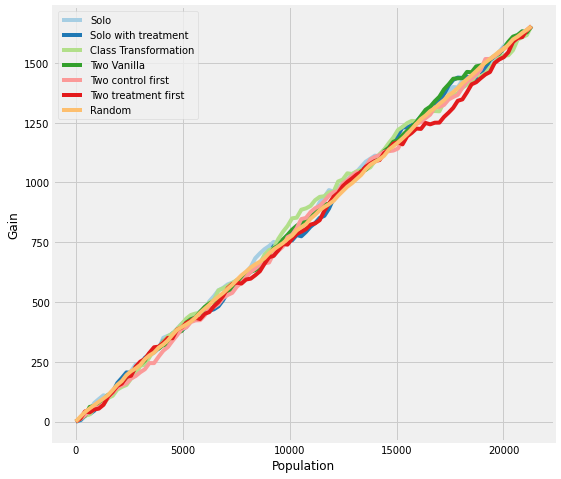

In [124]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'Solo': pred_1, 'Solo with treatment': pred_2, 'Class Transformation': pred_3,
                   'Two Vanilla': pred_4, 'Two control first': pred_5, 'Two treatment first': pred_6})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [125]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


Solo                    0.508227
Solo with treatment     0.501455
Class Transformation    0.505779
Two Vanilla             0.505127
Two control first       0.496880
Two treatment first     0.491472
Random                  0.502244
dtype: float64

## Comparison between the two campaigns

For comparison, we repeat here the same steps by chosing the Womens campaign.

In [126]:
data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=2)

### Base learners with Random Forest


In [127]:
solo_model = SoloModel(RandomForestClassifier())
solo_model = solo_model.fit(X_train, y_train, w_train)
pred_1 = solo_model.predict(X_test)

solo_model_w_treatment = SoloModel(RandomForestClassifier(), method='treatment_interaction')
solo_model_w_treatment = solo_model_w_treatment.fit(X_train, y_train, w_train)
pred_2 = solo_model_w_treatment.predict(X_test)

class_model = ClassTransformation(RandomForestClassifier())
class_model = class_model.fit(X_train, y_train, w_train)
pred_3 = class_model.predict(X_test)

two_models_vanilla = TwoModels(estimator_trmnt=RandomForestClassifier(), estimator_ctrl=RandomForestClassifier())
two_models_vanilla = two_models_vanilla.fit(X_train, y_train, w_train)
pred_4 = two_models_vanilla.predict(X_test)

two_models_c = TwoModels(estimator_trmnt=RandomForestClassifier(), estimator_ctrl=RandomForestClassifier(), method='ddr_control')
two_models_c = two_models_c.fit(X_train, y_train, w_train)
pred_5 = two_models_c.predict(X_test)

two_models_t = TwoModels(estimator_trmnt=RandomForestClassifier(), estimator_ctrl=RandomForestClassifier(), method='ddr_treatment')
two_models_t = two_models_t.fit(X_train, y_train, w_train)
pred_6 = two_models_t.predict(X_test)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


### Uplift curve

We plot the uplift curve by using the dedicated function from the CausalML package. We estimate the area under the curve
to compare the different models.

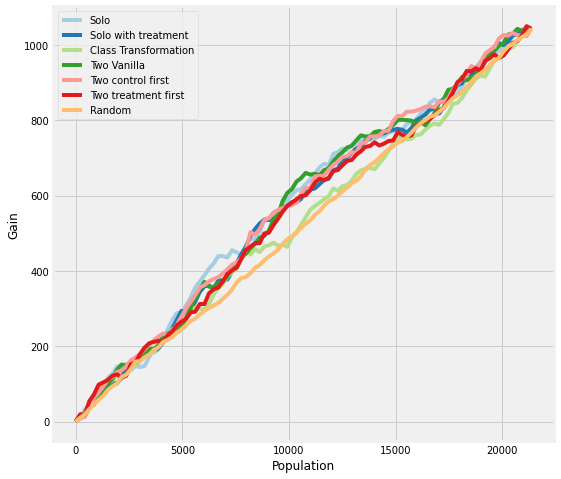

In [128]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'Solo': pred_1, 'Solo with treatment': pred_2, 'Class Transformation': pred_3,
                   'Two Vanilla': pred_4, 'Two control first': pred_5, 'Two treatment first': pred_6})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [129]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


Solo                    0.550954
Solo with treatment     0.539760
Class Transformation    0.509272
Two Vanilla             0.545670
Two control first       0.548718
Two treatment first     0.532093
Random                  0.500102
dtype: float64